# Moving Average Crossover Vectorised Backtest

In [2]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from dateutil.parser import parse
import cPickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import datetime
from sklearn.metrics import calinski_harabaz_score
import scipy

## Importing and scaling prices 

To start with we need to download price data. We can get them from quantopian (if we run this code in a research notebook) or Google. Here, we also produce random time series which we can employ later to test our strategy. In order to save time, we can also save the data to a file rather then downloading the whole dataset every time. 
In order to create a more balanced portfolio, we scale our prices between 0 and 1. In a really strict sense, this is somewhat forward looking, since we need knowledge about our maximum and minimum prices beforehand. However, this condition is not very strong and it helps us a great deal to run very fast vectorised backtests. 
The output of our function is a Pandas data frame. 

In [3]:
def prices(tickers,start,end,backend='google'):
    if backend == 'quantopian':
        p = get_pricing(tickers,start,end)
        field = 'price'

    elif backend == 'google':
        p = web.DataReader(tickers, 'google', parse(start), parse(end)).ffill()
        field = 'Close'
        cPickle.dump(p,open('prices.pick','w'))

    elif backend == 'random':
        field = 'Close'
        p = web.DataReader(tickers, 'google', parse(start), parse(end)).ffill()
        for ticker in tickers:
            p[field][ticker] = np.cumsum(np.random.randn(len(p[field][ticker]))-0.0)+500

    elif backend == 'file':
        p = cPickle.load(open('prices.pick'))
        p = p.loc[:,parse(start):parse(end)]
        field = 'Close'


    # pp=pd.DataFrame(p[field],index=p[field].index,columns = tickers)
    scaled = MinMaxScaler((0,1)).fit_transform(p[field])
    pp=pd.DataFrame(scaled,index=p[field].index,columns = tickers)
    return pp



## Calculation of MA-Crossover signals

Calculate the rolling means of the price data and subtract them from each other. Since this produces signals between +2 and -2, multiplying them with the prices would give us a strategy that is either long only if the first signal is positive or short only if the first signal is negative. In order to get a long-short strategy, we need to half the first signal. As a result the strategy now oscillates between +1 and -1 and it is independent of the starting direction.

In [4]:
def calc_signals(tickers,p,a,b):
    sma = p.rolling(a).mean()
    smb = p.rolling(b).mean()
    signal = np.sign(sma - smb).diff()
    actual_signals = signal.dropna(how='all',axis=0)
    for col in actual_signals.columns:
        idx = actual_signals[col].first_valid_index()
        signal[col][idx] = signal[col][idx]/2.
    return signal

## Calculation of PnL for prices and signals

Vectorised calculation of the PnL curve is simple if we just take the trades (positive signal values) into account. However, continuous PnL can be more difficult as we have to treat longs and shorts separately. There are many ways to do this, one of them is shown below.

In [5]:
def calc_pnl(sig,p):
    sig_up = sig.cumsum().apply(lambda x:x*(x>0))
    sig_dwn = sig.cumsum().apply(lambda x:x*(x<0))
    pnlx = np.cumsum(p.diff()*sig_up+p.diff()*sig_dwn).sum(axis=1)
    return pnlx

## Calculation of Sharpe ratio for prices and signals

For Sharpe ratio calculations we need to eliminate NaN's and infinite values. In Numpy we can conveniently use nanmean and nanstd for this and only eliminate infinite values separately. The square root of 252 indicates the we have annualised our Sharpe and we ommit the risk-free rate as it is currently close to zero. Ideally, it should be taken into account as it has been significantly higher in the past. In our case we use the Sharpe ratio more as a comparison of the same strategy with different parameters, which turns the Sharpe calculation into a relative metric.

In [6]:
def calc_sharpe(pnl):
    retsx = np.diff(pnl)
    retsx = retsx[~np.isinf(retsx)]
    sharpe = np.nanmean(retsx)/np.nanstd(retsx)*np.sqrt(252)
    return sharpe

## Calculation of drawdown for prices and signals

In this case we look at the drawdown in absolute terms. This is much simpler and acceptable since we are only using it to compare identical strategies with different parameters. Using relative drawdown, we would have to introduce to notion of cash balance, which would make our vectorised calculations much more complex and slower.

In [7]:
def calc_ddwn(pnl):
    hwm = 0
    ddwn = []
    for i in pnl:
        if i>hwm:
            hwm = i
        ddwn.append(i - hwm)
    return np.nanmin(ddwn)

## Code for single run

This is the function to perform a single run and calculate the metrics.

In [8]:
def run_single(tickers, p):
    sig = calc_signals(tickers,p,10,20)
    pnl = calc_pnl(sig,p)
    sharpe = calc_sharpe(pnl)
    ddwn = calc_ddwn(pnl)
    return pnl,sharpe,ddwn


## Get the price data

This code just gets the price data and scales them between 0 and 1.

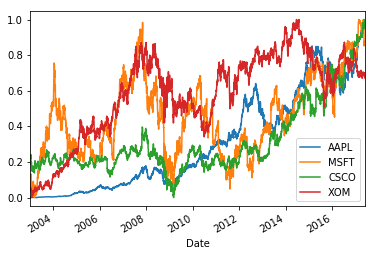

In [9]:
# BACKEND = 'google'
BACKEND = 'file'
tickers = ['AAPL','MSFT','CSCO','XOM']
start = '2003-01-01'
end = '2017-06-01'
p = prices(tickers,start,end,backend=BACKEND)
p.plot()
plt.show()



## Run single backtest

This is the code to run a single backtest and plot the PnL curve. We can see that the backtest runs very fast.

In [10]:
% timeit pnl,sharpe,ddwn = run_single(tickers,p)
plt.plot(pnl)
plt.show()

100 loops, best of 3: 15.2 ms per loop


NameError: name 'pnl' is not defined

## Test the metric calculations

In order to make sure that the calculations of our signals and metrics make sense, we build some tests where we simply apply a step function to our backtest.

In [ ]:
def test_pnl():
    rets = np.zeros(1000)
    rets[500] = 1
    pr = np.cumsum(rets)

    df = pd.DataFrame(pr)
    sig = calc_signals(1,df,10,20)
    pnl = calc_pnl(sig,df)
    plt.subplot(3,1,1)
    plt.plot(df)
    plt.ylabel('price')
    plt.subplot(3,1,2)
    plt.plot(sig)
    plt.ylabel('signal')
    plt.subplot(3,1,3)
    plt.plot(pnl)
    plt.ylabel('pnl')
    plt.xlabel('time')
    plt.show()

In [ ]:
def test_ddwn():
    k = np.random.randn(1000)
    ddwn = calc_ddwn(np.cumsum(k))
    plt.plot(np.cumsum(k))
    plt.xlabel('time')
    plt.ylabel('price')
    plt.title('drawdown: %s'%ddwn)
    plt.show()

The results of the PnL tests show what we expect: a step function in the price curve, a subsequent buy and sell signal and a step in the PnL curve.

In [ ]:
test_pnl()

Looking at the test results below we can check if the calculate drawdown agrees with the PnL curve.

In [ ]:
test_ddwn()

## Sharpe ratio

Be aware of the hidden intricacies of the Sharpe ratio.
Both graphs below have the same Sharpe ratio but very different behaviour when we sort the returns. We can see that for the sorted returns we would get wiped out very quickly despite the decent Sharpe.

In [ ]:
def plot_sharpe():
    k = np.random.randn(1000)+0.08
    p = np.cumsum(k)+100
    p_sorted = np.cumsum(np.sort(k))+100
    print np.mean(k)/np.std(k)*np.sqrt(252)

    plt.plot(p)
    plt.plot(p_sorted)
    plt.xlabel('time')
    plt.ylabel('price')
    plt.show()
    
plot_sharpe()

# Parameter Sweep

This function runs individual backtests from a list of input parameters. We need to sort the parameters first to get a consistent MA-crossover strategy that captures momentum. 

In [18]:
def parameter_sweep(tickers,p,params,N,progress = False):
    pnls = []
    sharpes = []
    ddwns = []
    new_params = []
    for i in range(N):
        if progress: print i
        a = min(params[i])
        b = max(params[i])
        if a==b: continue
        try:
            sig = calc_signals(tickers,p,a,b)
            pnl = calc_pnl(sig,p)
            pnls.append(pnl[-1])
            sharpes.append(calc_sharpe(pnl))
            ddwns.append(calc_ddwn(pnl))
            new_params.append([a,b])

        except:
            pnls.append(np.nan)
            sharpes.append(np.nan)
            ddwns.append(np.nan)
            new_params.append([a,b])

    return pnls,sharpes,ddwns,new_params

This function runs the parameter sweeps for training and test set. The strategy is separated by a mid-point which is specified as the fraction of the train period with respect to the whole time period.

In [170]:
def run_parameter_sweep(tickers,start,end,BACKEND,N):
    sm = 4
    lm = 250
    frac = 0.7
    mid_point = str(datetime.timedelta((parse(end)-parse(start)).days*frac)+parse(start))
    print 'MID POINT:', mid_point
    print 'BACKEND:',BACKEND
    params = np.array([np.random.randint(sm,lm,(N,)) for i in range(2)]).T
    # plt.plot(params[:,0],params[:,1],'o')
    # plt.xlabel('parameter 1')
    # plt.ylabel('parameter 2')
    # plt.show()

    p0 = prices(tickers,start,mid_point,backend=BACKEND)
    pnls1,sharpes1,ddwns1,new_params = parameter_sweep(tickers,p0,params,N,progress=False)

    p1 = prices(tickers,mid_point,end,backend=BACKEND)
    pnls2,sharpes2,ddwns2,new_params = parameter_sweep(tickers,p1,params,N,progress=False)
    return pnls1,sharpes1,ddwns1,pnls2,sharpes2,ddwns2,new_params

In [171]:
pnls1,sharpes1,ddwns1,pnls2,sharpes2,ddwns2,params = run_parameter_sweep(tickers,start,end,BACKEND,30000)
cPickle.dump([pnls1,pnls2],open('pnls.pick','w'))
cPickle.dump(params,open('params.pick','w'))
cPickle.dump([sharpes1,sharpes2],open('sharpes.pick','w'))
cPickle.dump([ddwns1,ddwns2],open('ddwns.pick','w'))

MID POINT: 2013-02-02 12:00:00
BACKEND: file


## Load precalculated PnLs

For demonstration, a list with 30,000 backtest has been pre-calculated. On my Mac Air, this process took less than 15 minutes.

In [172]:
#cPickle.dump([pnls1,pnls2],open('pnls_opt.pick','w'))
#cPickle.dump(params,open('params_opt.pick','w'))
pnls1,pnls2 = cPickle.load(open('pnls.pick'))
params = cPickle.load(open('params.pick'))

Now we are plotting histogams for the PnL distibutions of training and test set. The shortfall between the means of the two can give us an indication of the out-of-sample shortfall. In this case, the strategy performs better in the test than in the training set. This indicates that this type of strategy would have performed better in recent periods. It also suggests that we may have set the bounds of our parameter range too wide.

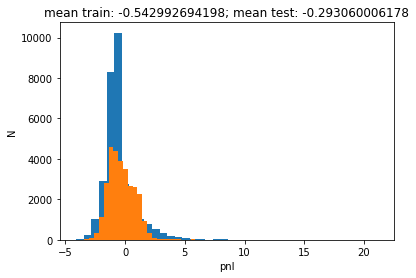

In [173]:
def plot_pnl_hist(pnls1,pnls2):
    plt.hist(pnls1,40)
    plt.hist(pnls2,40)
    mean1 = np.mean(pnls1)
    mean2 = np.mean(pnls2)
    plt.xlabel('pnl')
    plt.ylabel('N')
    plt.title('mean train: %s; mean test: %s'%(mean1,mean2))
    plt.show()
    
plot_pnl_hist(pnls1,pnls2)

## Plot of train-test correlation

Here comes probably the most interesting part of this exercise. We plot the correlation of the PnLs between the train and the test set for ALL individual backtests. If our strategy has some merit we expect to see some correlation between the two at least in some regions. Since we are looking at a MA-crossover, we will probably not see a correlation across the entire parameter space. Our strategy is designed to pick up either trending or mean reverting behaviour. However, we know from analysis of the Hurst exponent that many of the stocks in the S&P are mean reverting in the 5 to 30 day periods and trending in the periods over roughly 100 days. 
The result shows that there are at least some regions that show correlations, so let's analyse them a bit more.

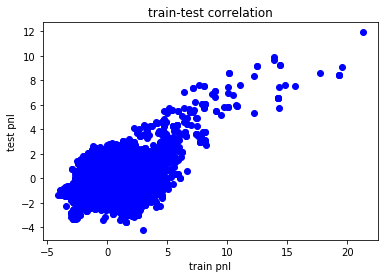

In [174]:
def show_train_test_correlation(pnls1,pnls2):
    plt.plot(pnls1,pnls2,'bo')
    plt.xlabel('train pnl')
    plt.ylabel('test pnl')
    plt.title('train-test correlation')
    plt.show()
    
show_train_test_correlation(pnls1,pnls2)

In [175]:
def plot_linreg(x,y):
    m = np.polyfit(x,y,1)
    xx = np.linspace(min(x),max(x),1000)
    yy = np.polyval(m,xx)
    plt.plot(xx,yy)
    return m

## Calculate the best number of clusters

Our ultimate aim is to automate this process entirely. This is not an easy task but we demonstrate here how this might be accomplished. First, let's isolate some of the clusters that might be interesting. We do this using the unsupervised K-Means machine learning algorithm. For K-Means to work, we need to specify the number of clusters we want to separate. Since we can't be sure how many clusters are optimal, we can try different numbers and then use the Calinski-Harabaz score to evaluate the quality of them. 

In [176]:
def get_cluster_number(X):
    score = 0
    best_cluster_number = 0
    for i in range(2,10):
        # kmeans = AgglomerativeClustering(n_clusters = i).fit(X)
        kmeans = KMeans(n_clusters=i).fit(X)
        chs = calinski_harabaz_score(X,kmeans.labels_)
        print 'cluster number -->', i, chs
        if chs>score:
            best_cluster_number = i
            score = chs
    return best_cluster_number-1

## Plot the clusters

When we run this procedure we find that the ideal cluster number is 7. Since we deal with 30,000 data points it is hard from the graph to tell visually what the cluster separation should look like. Below, the clusters are plotted in different colors. We can immediately see that the cluster with the highest train-test PnL has some correlation. Let's drill into this cluster further.

cluster number --> 2 18056.9465774
cluster number --> 3 19560.268479
cluster number --> 4 19833.304089
cluster number --> 5 19972.0296368
cluster number --> 6 19696.1582698
cluster number --> 7 20344.0537912
cluster number --> 8 21461.8968484
cluster number --> 9 21151.1430786


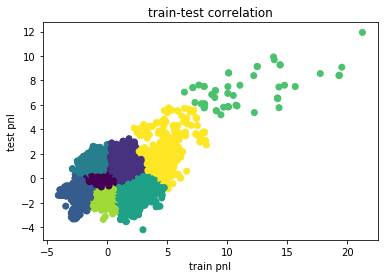

In [177]:
def plot_clusters(pnls1,pnls2):
    Nc = get_cluster_number(np.array([pnls1,pnls2]).T)
    kmeans = KMeans(n_clusters=Nc+1).fit(np.array([pnls1,pnls2]).T)
    #cPickle.dump(kmeans,open('kmeans.pick','w'))
    plt.scatter(pnls1,pnls2,c=kmeans.labels_);
    cPickle.dump([pnls1,pnls2],open('pnls.pick','w'))
    plt.xlabel('train pnl')
    plt.ylabel('test pnl')
    plt.title('train-test correlation')
    plt.show()
    return kmeans,Nc

kmeans,Nc = plot_clusters(pnls1,pnls2)
plt.show()

## Find and plot the best cluster automatically

The next functions automatically isolate the cluster and plot the linear regression line over them. 

In [178]:
def find_best_cluster(kmeans):
    median_oos_pnl = []
    for label in np.unique(kmeans.labels_):
        median_pnl = np.median(np.array(pnls2)[kmeans.labels_==label])
        median_oos_pnl.append(median_pnl)
    center_mean = np.argmax(np.mean(kmeans.cluster_centers_,axis=1))
    opt_label = np.argmax(median_oos_pnl)
    if center_mean!=opt_label:
        print 'Warning: best center mean is different from median oos pnl'
    return opt_label

In [179]:
def plot_best_cluster(kmeans):
    opt_label = find_best_cluster(kmeans)
    x = np.array(pnls1)[kmeans.labels_==opt_label]
    y = np.array(pnls2)[kmeans.labels_==opt_label]
    plt.scatter(x,y)
    m = plot_linreg(x,y)
    plt.title('slope of regression: %s'%m[0])
    plt.xlabel('train pnl')
    plt.ylabel('test pnl')
    return opt_label

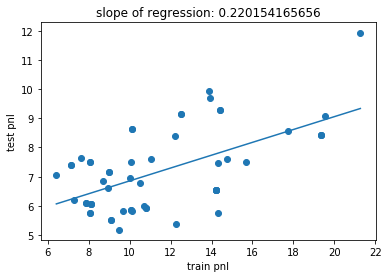

In [180]:
opt_label = plot_best_cluster(kmeans)
plt.show()

Here, we jump ahead a bit. We've ran a parameter sweep with only the parameters that are used in the cluster above. Next, we ran a regression of the ranked PnLs and find an impressive rank correlation. This tells us that in our reduced parameter space we get a very strong predictive behaviour between train and test data.

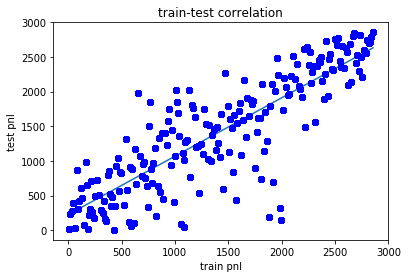

In [181]:
pnls1_opt,pnls2_opt = cPickle.load(open('pnls_opt.pick'))
params_opt = cPickle.load(open('params_opt.pick'))
plot_linreg(scipy.stats.rankdata(pnls1_opt),scipy.stats.rankdata(pnls2_opt))
show_train_test_correlation(scipy.stats.rankdata(pnls1_opt),scipy.stats.rankdata(pnls2_opt))

The PnL distribution is also very interesting. The shortfall between the train and the test PnL is due to the fact that our test period is less than half the length of the train period. 

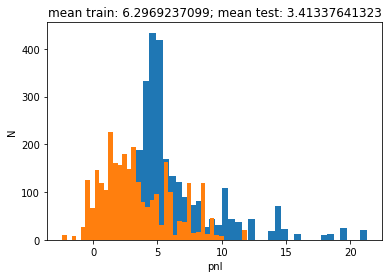

In [182]:
plot_pnl_hist(pnls1_opt,pnls2_opt)

## Plot the parameters of the best cluster

We have already shown the ranked correlation of the parameters in our best cluster above and found that train and test PnLs correlate very well. However, we it is useful to visualise the location of these parameters in our parameter space. If we find that they are scattered randomly, the strategy will not be very useful. 
The figure below shows that our parameters are clustered very strongly in the lower corner of our parameter space. This is a positive result and indicates that our trading strategy will be relatively short-term.

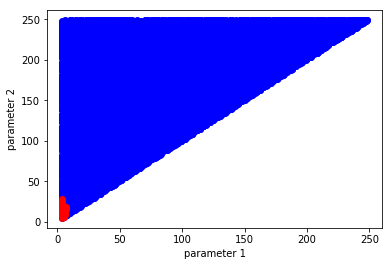

In [183]:
def plot_best_parameters(kmeans):
    opt_label = find_best_cluster(kmeans)
    params = cPickle.load(open('params.pick'))
    plt.plot(np.array(params)[:,0],np.array(params)[:,1],'bo')
    plt.plot(np.array(params)[kmeans.labels_==opt_label,0],np.array(params)[kmeans.labels_==opt_label,1],'ro')
    plt.xlabel('parameter 1')
    plt.ylabel('parameter 2')
    
plot_best_parameters(kmeans)
plt.show()

## Print the best parameters

In [184]:
def get_best_parameters(params,pnls,N):
    idx = np.argsort(pnls)
    unique_params = np.unique(np.array(params)[idx][-N:],axis=0)
    return unique_params

## Plot the PnLs of the best parameters

Let's now plot the PnL curves of our favourite parameter pairs. They look quite reasonable.
We also print the fraction of days with trading with repect to the overall number of days. From this we can se that we trade approximately every 5 to 18 days. This is important when we take trading costs into account. 

[4 5]
Fraction of trade days: 0.270074503311
[4 6]
Fraction of trade days: 0.191898978747
[4 7]
Fraction of trade days: 0.157095527333
[4 9]
Fraction of trade days: 0.123756906077
[ 4 10]
Fraction of trade days: 0.112462006079
[ 4 11]
Fraction of trade days: 0.10461580984
[ 4 13]
Fraction of trade days: 0.092298119469
[ 4 14]
Fraction of trade days: 0.0860995850622
[5 6]
Fraction of trade days: 0.237648357715
[5 7]
Fraction of trade days: 0.170485919382


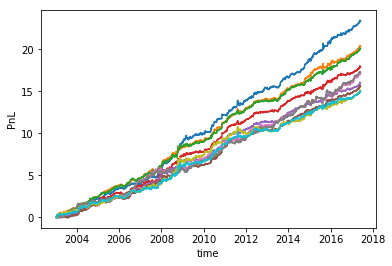

In [185]:
def plot_best_params(params,tickers,start,end,BACKEND):
    p = prices(tickers,start,end,backend=BACKEND)
    curves = []
    for par in params:
        print par
        signals = calc_signals(tickers,p,min(par),max(par))
        print 'Fraction of trade days:',(sign(signals.dropna()).abs().sum()/len(signals.dropna())).mean()
        pnl = (calc_pnl(signals,p))
        plt.plot(p.index,(calc_pnl(calc_signals(tickers,p,min(par),max(par)),p)))
        curves.append(pnl.diff().fillna(0))
    plt.xlabel('time')
    plt.ylabel('PnL')
    return curves
    
best_params = get_best_parameters(params,pnls1,15)
curves = plot_best_params(best_params,tickers,start,end,BACKEND)
plt.show()

Looking at the covariance matrix of the returns we can see that some of them have fairly low correlation. This means we could include them in a "strategy portfolio" which trades several low-correlated strategies rather than different assets. Plotting a graph of the different correlation coefficients, the gap suggests that there is some more structure in the data that we have not been aware of so far.

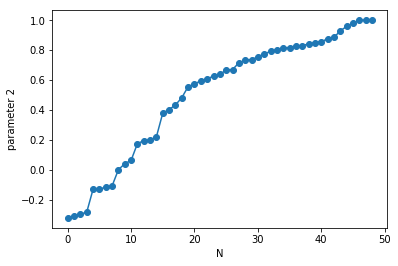

In [186]:
correlations = sort(np.unique(np.triu(np.corrcoef(curves))))
plt.plot(correlations,'-o')
plt.xlabel('N')
plt.ylabel('parameter 2')
plt.show()

## Plot the PnL surface of the best parameters

Plotting the response surface of the PnL based on the parameter space might help to identify more structure in the data. Here, we show how to plot the data points and superimpose a rectangular grid over them, that can help the visualisation. 
It is apparent that the surface is quite smooth. We don't have excessive peaks or troughs, which is what we want. When we move the plot we can also see some diagonal ridges and valleys. Since we are dealing with moving average, the diagonal positions indicate that the difference between our parameters matters. This could be explored further but we will not do this right now.

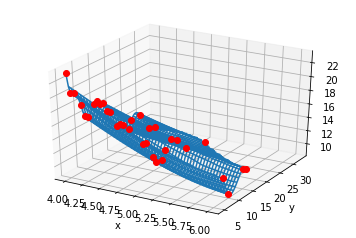

In [187]:
def plot_response_surface(pnls,params,tickers,start,end,backend='file'):
    from mpl_toolkits.mplot3d import Axes3D
    p = prices(tickers,start,end,backend=backend)
    best_params = get_best_parameters(params,pnls,50)
    x = []
    y = []
    z = []
    for par in best_params:
        x.append(par[0])
        y.append(par[1])
	z.append(calc_pnl(calc_signals(tickers,p,min(par),max(par)),p)[-1])
    n_points = 50
    X,Y = np.meshgrid(np.linspace(min(x),max(x),n_points),np.linspace(min(y),max(y),n_points))
    Z = scipy.interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y),method='cubic')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z,'ro')
    ax.plot_wireframe(X,Y,Z)
    plt.xlabel('x');plt.ylabel('y')
    
plot_response_surface(pnls1,params,tickers,start,end)
plt.show()

## Bootstrapping

Bootstrapping is the technique of random sampling from a return distribution and analysing the mean distribution of the final PnLs of the resulting curves. The observed shortfall will give us an indication how reliable our orginal PnL curve is as a measure for the quality of our strategy. In our case the shortfall is very small, another indication that our strategy has merit. 

actual pnl: 20.3558042941  bootstrapped mean pnl:  20.3371259238


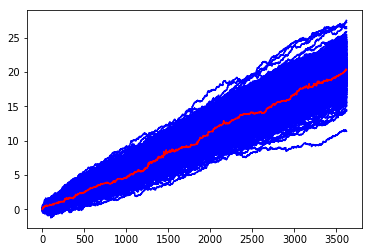

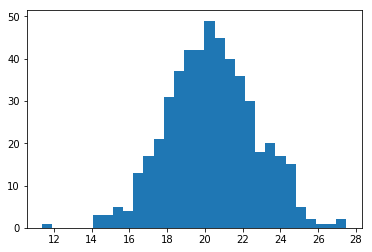

In [196]:
def bootstrap(pnls,params,tickers,start,end,backend='file'):
    p = prices(tickers,start,end,backend=backend)
    best_params = get_best_parameters(params,pnls,50)
    pnl = calc_pnl(calc_signals(tickers,p,min(best_params[0]),max(best_params[1])),p)
    rets = np.diff(pnl)
    rets = rets[~np.isnan(rets)]
    last = []
    for i in range(500):
        k = np.random.choice(rets,len(rets))
        ps = np.cumsum(k)
        if ~np.isnan(ps[-1]):
            last.append(ps[-1])
        plot(ps,'b-')
    plot(np.cumsum(rets),'r-')
    print 'actual pnl:',np.cumsum(rets)[-1],' bootstrapped mean pnl: ',np.nanmean(last)
    show()
    hist(last,30)
    show()
    
bootstrap(pnls2,params,tickers,start,end,backend='file')

## Relationship Between PnL, Sharpe and Drawdown

Next, let's look at the relationships between PnL, Sharpe and drawdown. Below we see the relationship between PnL and the Sharpe ratio is very linear, indicating that most of our strategies are "well behaved" without excessive tail risk. Abnormal returns in some of the strategies would result in noticable outliers. 

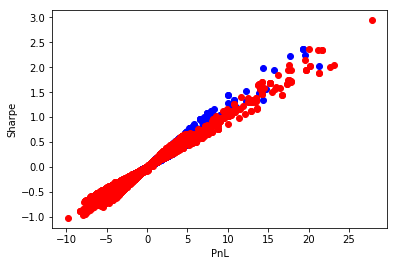

In [212]:
sharpes1,sharpes2 = cPickle.load(open('sharpes.pick'))
plt.plot(np.array(pnls1),sharpes1,'bo')
plt.plot(np.array(pnls2)*(7/3.),sharpes2,'ro')
plt.xlabel('PnL')
plt.ylabel('Sharpe')
plt.show()

The drawdowns are mostly well-correlated to the PnLs as well. We find that at the higher end of the PnLs the drawdown saturates. This is the return distribution will in practise not go to zero as it is determined by the intra-day volatility of the individual stocks.


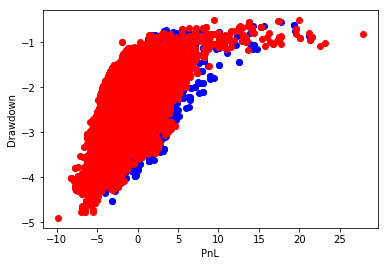

In [211]:
ddwns1,ddwns2 = cPickle.load(open('ddwns.pick'))
plt.plot(np.array(pnls1),np.array(ddwns1),'bo')
plt.plot(np.array(pnls2)*(7/3.),ddwns2,'ro')
plt.xlabel('PnL')
plt.ylabel('Drawdown')
plt.show()

Since Sharpe ratio is highly correlated with PnL we expect its relationship with drawdown to be very similar to the previous one.

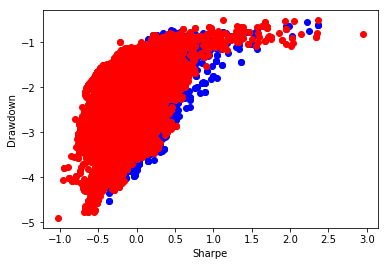

In [210]:
plt.plot(sharpes1,ddwns1,'bo')
plt.plot(sharpes2,ddwns2,'ro')
plt.xlabel('Sharpe')
plt.ylabel('Drawdown')
plt.show()

## Using Machine Learning Models to Predict PnL 

In [247]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [270]:
model = SVR()
#model = LinearRegression()
model = DecisionTreeRegressor()
M = 25000
model.fit(array(params)[:-M,:],pnls1[:-M])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [271]:
pred_pnls = model.predict(array(params)[-M:,:])

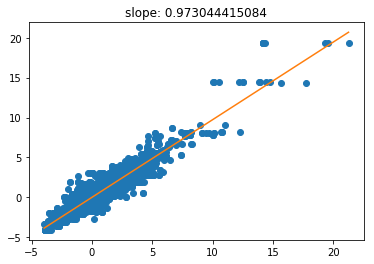

In [272]:
plt.plot(pnls1[-M:],pred_pnls,'o')
m = plot_linreg(pnls1[-M:],pred_pnls)
plt.title('slope: %s'%m[0])
plt.show()